<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part7/P7_Ch02_CH00%2C01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인물사진에서 성별과 표정분석하기

## Dataset : celeb_a dataset
- 100177명
- 202599개 이미지
- 5개의 랜드마크 위치, 이미지당 40개의 바이너리 속성 주석
    - 성별
    - 큰코
    - 매력적
    - 젊음
    - 웃음여부
    - 등등

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## 1. 도입전 기본 처리

### tfds를 이용하여 데이터셋 사용하기

In [2]:
import tensorflow_datasets as tfds
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 'conll2003',
 'controlled_noisy_web_labels'

### celeba의 정보중 이용할 데이터만 추출

In [ ]:
celeb_a =tfds.load('celeb_a')

### 데이터량 축소


In [ ]:
import imageio
from skimage.transform import resize

celeb_a_train, celeb_a_test =celeb_a['validation'], celeb_a['test']

train_images =[]
train_labels = []

for tensor in tfds.as_numpy(celeb_a_train):
    isMale = tensor['attributes']['Male']
    isSmiling = tensor['attributes']['Smiling']

    label = np.array([isMale, isSmiling]).astype(np.int8)

    img = resize(tensor['image'], (190//1.5, 89//1.5))

    train_images.append(img)
    train_labels.append(label)

test_images =[]
test_labels = []

for tensor in tfds.as_numpy(celeb_a_test):
    isMale = tensor['attributes']['Male']
    isSmiling = tensor['attributes']['Smiling']

    label = np.array([isMale, isSmiling]).astype(np.int8)

    img = resize(tensor['image'], (190//1.5, 89//1.5))

    test_images.append(img)
    test_labels.append(label)


In [ ]:
#imbalance 처리

m_s =[]
f_s =[]
m_n =[]
f_n =[]

for a, b in zip(test_images, test_labels):
    if b[0] and b[1]:
        m_s.append((a, b))
    elif not b[0] and b[1]:
        f_s.append((a, b))
    elif b[0] and not b[1]:
        m_n.append((a, b))
    elif not b[0] and not b[1]:
        f_n.append((a, b))


In [ ]:
print(len(m_s), len(m_n), len(f_s), len(f_n))
total = m_s[:550] + m_n[:550] + f_s[:550] + f_n[:550]
print(len(total))

In [ ]:
import random
random.shuffle(total)
trains = total[:2000]
tests = total[2000:]
print(len(trains), len(tests))

In [ ]:
train_images, train_labels =list(zip(*trains))
test_images, test_labels =list(zip(*tests))

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

### 사전 저장된 celeba small데이터 확인

In [4]:
!ls -ai /content/drive/MyDrive/딥러닝_정주행/P7_Ch02.인물사진성별표정분석/celeba_small.npz

65 /content/drive/MyDrive/딥러닝_정주행/P7_Ch02.인물사진성별표정분석/celeba_small.npz


In [7]:
celeba_small = np.load('/content/drive/MyDrive/딥러닝_정주행/P7_Ch02.인물사진성별표정분석/celeba_small.npz')
print(list(celeba_small.keys()))
x = celeba_small['train_images'][0]
y = celeba_small['train_labels'][0]

['train_images', 'train_labels', 'test_images', 'test_labels']


In [8]:
x.shape, y.shape

((72, 59, 3), (2,))

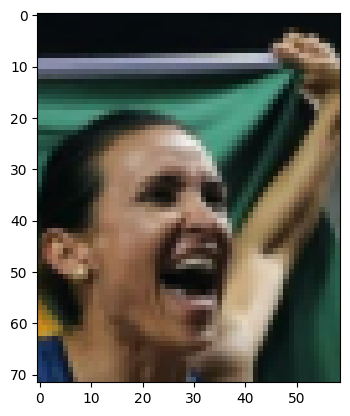

[0 0]


In [9]:
plt.imshow(x)
plt.show()
print(y)

In [10]:
celeba_small = np.load('/content/drive/MyDrive/딥러닝_정주행/P7_Ch02.인물사진성별표정분석/celeba_small.npz')

train_images = celeba_small['train_images']
train_labels = celeba_small['train_labels']

test_images = celeba_small['test_images']
test_labels = celeba_small['test_labels']

In [11]:
train_images[train_images !=0][:10]

array([0.02352941, 0.04313725, 0.05490196, 0.01960784, 0.03921569,
       0.05490196, 0.01977401, 0.03921569, 0.05114656, 0.02352941])

In [12]:
train_images.dtype

dtype('float64')